In [25]:
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Solution (a): Image Classification with FNN's

In this section I have chosen 3 combinations of hyperparameters for FNN's which covers hyperparameters from layers, dropout, number of epochs to many more!

# Solution - a(i)
The best hyperparameter combination I found was combination 2:

* "layers": [512, 256, 128, 64].
* "activation": 'leaky_relu'.
* "dropout": 0.3.
* "l2_reg": 0.0.
* "optimizer": RMSprop(learning_rate=0.0005).
* "batch_size": 64.
* "epochs": 25.

The recorded training accuracy was 48.25% and validation accuracy was 43.44%.

Here is the full list of parameters tracked for each combination:

--- Combination 1 ---

* Final Train Accuracy: 0.3070
* Final Validation Accuracy: 0.2879
* Training Time (s): 54.35
* Total Parameters: 3093514

--- Combination 2 ---

* Final Train Accuracy: 0.4825
* Final Validation Accuracy: 0.4333
* Training Time (s): 64.24
* Total Parameters: 701770

--- Combination 3 ---

* Final Train Accuracy: 0.2522
* Final Validation Accuracy: 0.2383
* Training Time (s): 92.80
* Total Parameters: 380426

In [65]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert to grayscale
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

In [66]:
# Flatten images to 1D arrays and normalize
X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], -1) / 255.0
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], -1) / 255.0

In [67]:
# Use one batch as validation
X_val, X_train_new = X_train_gray[:10000], X_train_gray[10000:]
y_val, y_train_new = y_train[:10000], y_train[10000:]

In [68]:
# One-hot encode labels
y_train_new = to_categorical(y_train_new, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [14]:
# Define hyperparameter combinations
combinations = [
    {
        "layers": [1024, 512, 256],
        "activation": 'tanh',
        "dropout": 0.2,
        "l2_reg": 1e-4,
        "optimizer": Adam(learning_rate=0.001),
        "batch_size": 128,
        "epochs": 30
    },
    {
        "layers": [512, 256, 128, 64],
        "activation": 'leaky_relu',  # Custom activation
        "dropout": 0.3,
        "l2_reg": 0.0,
        "optimizer": RMSprop(learning_rate=0.0005),
        "batch_size": 64,
        "epochs": 25
    },
    {
        "layers": [256, 128],
        "activation": 'relu',
        "dropout": 0.1,
        "l2_reg": 1e-3,
        "optimizer": Adam(learning_rate=0.001),
        "batch_size": 32,
        "epochs": 20
    }
]

In [15]:
results = []

# Train and evaluate each combination
for i, combo in enumerate(combinations):
    print(f"Combination {i+1}: {combo}")

    # Build the model
    inputs = Input(shape=(1024,))
    x = Dense(combo["layers"][0], kernel_regularizer=l2(combo["l2_reg"]))(inputs)
    if combo["activation"] == 'leaky_relu':
        x = LeakyReLU(negative_slope=0.1)(x)  # Updated parameter for LeakyReLU
    else:
        x = Dense(combo["layers"][0], activation=combo["activation"], kernel_regularizer=l2(combo["l2_reg"]))(x)
    x = BatchNormalization()(x)  # Add batch normalization
    x = Dropout(combo["dropout"])(x)

    # Add hidden layers
    for layer_size in combo["layers"][1:]:
        x = Dense(layer_size, kernel_regularizer=l2(combo["l2_reg"]))(x)
        if combo["activation"] == 'leaky_relu':
            x = LeakyReLU(negative_slope=0.1)(x)
        else:
            x = Dense(layer_size, activation=combo["activation"], kernel_regularizer=l2(combo["l2_reg"]))(x)
        x = BatchNormalization()(x)
        x = Dropout(combo["dropout"])(x)

    # Output layer
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=combo["optimizer"], loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback for learning rate adjustment
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    # Train the model with timing
    start_time = time.time()
    history = model.fit(
        X_train_new, y_train_new,
        validation_data=(X_val, y_val),
        epochs=combo["epochs"],
        batch_size=combo["batch_size"],
        callbacks=[lr_scheduler],
        verbose=1
    )
    training_time = time.time() - start_time

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train_new, y_train_new, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

    # Save results
    results.append({
        "Combination": i + 1,
        "Hyperparameters": combo,
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time (s)": training_time,
        "Parameter Count": model.count_params(),
        "Training Loss": history.history["loss"],
        "Validation Loss": history.history["val_loss"]
    })

    print(f"Finished Combination {i+1}")

Combination 1: {'layers': [1024, 512, 256], 'activation': 'tanh', 'dropout': 0.2, 'l2_reg': 0.0001, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7d395340e3e0>, 'batch_size': 128, 'epochs': 30}
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.1900 - loss: 2.8019 - val_accuracy: 0.1219 - val_loss: 2.8447 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2242 - loss: 2.5103 - val_accuracy: 0.1219 - val_loss: 2.7824 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2677 - loss: 2.3296 - val_accuracy: 0.0947 - val_loss: 2.8761 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3043 - loss: 2.1776 - val_accuracy: 0.1131 - val_loss: 3.3664 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3250 - loss: 2.0894 - val_accuracy: 0.1029 - val_loss: 2.9869 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━

In [16]:
# Display results
for result in results:
    print("\n--- Combination", result["Combination"], "---")
    print("Hyperparameters:", result["Hyperparameters"])
    print(f"Final Train Accuracy: {result['Train Accuracy']:.4f}")
    print(f"Final Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f"Training Time (s): {result['Training Time (s)']:.2f}")
    print(f"Total Parameters: {result['Parameter Count']}")


--- Combination 1 ---
Hyperparameters: {'layers': [1024, 512, 256], 'activation': 'tanh', 'dropout': 0.2, 'l2_reg': 0.0001, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7d395340e3e0>, 'batch_size': 128, 'epochs': 30}
Final Train Accuracy: 0.3070
Final Validation Accuracy: 0.2879
Training Time (s): 54.35
Total Parameters: 3093514

--- Combination 2 ---
Hyperparameters: {'layers': [512, 256, 128, 64], 'activation': 'leaky_relu', 'dropout': 0.3, 'l2_reg': 0.0, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x7d39534e3730>, 'batch_size': 64, 'epochs': 25}
Final Train Accuracy: 0.4825
Final Validation Accuracy: 0.4333
Training Time (s): 64.24
Total Parameters: 701770

--- Combination 3 ---
Hyperparameters: {'layers': [256, 128], 'activation': 'relu', 'dropout': 0.1, 'l2_reg': 0.001, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7d395340e050>, 'batch_size': 32, 'epochs': 20}
Final Train Accuracy: 0.2522
Final Validation Accuracy: 0.2383
Training Time (s)

# Solution - a(ii)

The test set accuracy for the best model (Combination 2) is recorded as 42.26%.

From the confusion matrix it can be observed that the classes 1 & 7 were more correctly classified when compared to other classes using this model!

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2062 - loss: 2.4103
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2924 - loss: 1.9837
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3221 - loss: 1.8967
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3388 - loss: 1.8461
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3550 - loss: 1.8204
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3664 - loss: 1.7840
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3744 - loss: 1.7705
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3770 - loss: 1.7462
Epoch 9/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3821 - loss: 1.7430
Epoch 10/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3904 - loss: 1.7197
Epoch 11/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3907 - loss: 1.7138
Epoch 12/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

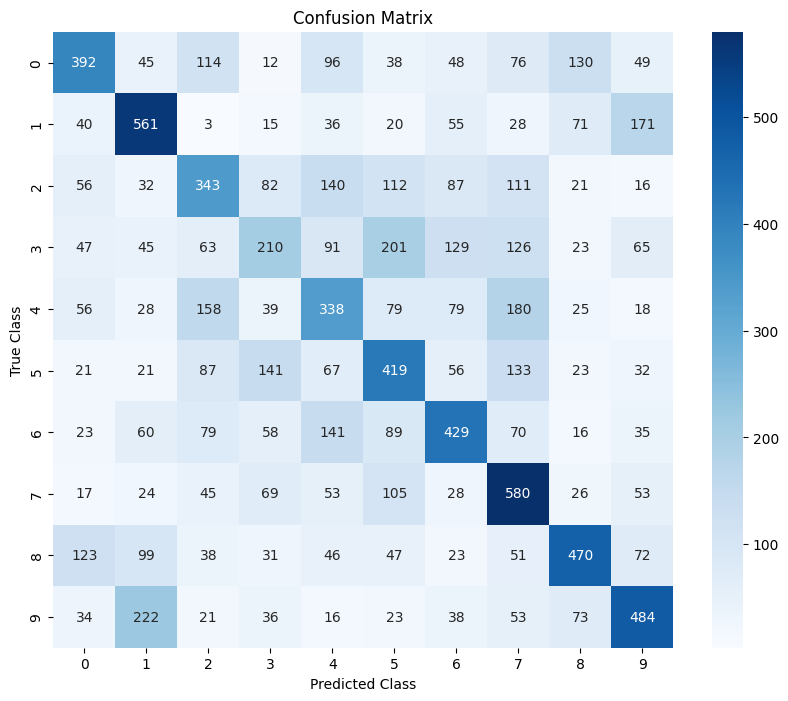


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.39      0.43      1000
           1       0.49      0.56      0.53      1000
           2       0.36      0.34      0.35      1000
           3       0.30      0.21      0.25      1000
           4       0.33      0.34      0.33      1000
           5       0.37      0.42      0.39      1000
           6       0.44      0.43      0.44      1000
           7       0.41      0.58      0.48      1000
           8       0.54      0.47      0.50      1000
           9       0.49      0.48      0.49      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000
weighted avg       0.42      0.42      0.42     10000



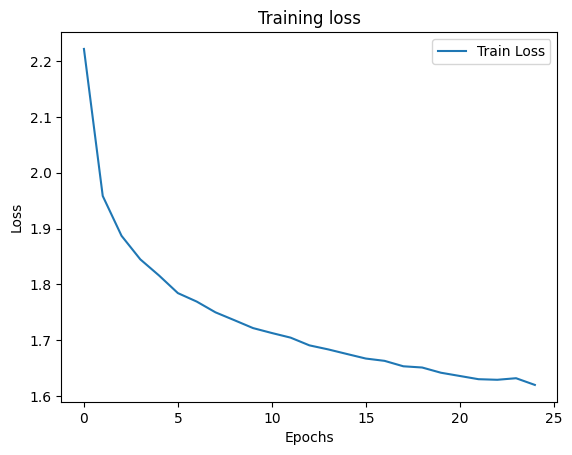

In [69]:
# Rebuilding the best model (Combination 2) - 48.25% test set accuracy and 43.33% validation set accuracy!!
best_combo = {
    "layers": [512, 256, 128, 64],
    "activation": 'leaky_relu',
    "dropout": 0.3,
    "l2_reg": 0.0,
    "optimizer": RMSprop(learning_rate=0.0005),
    "batch_size": 64,
    "epochs": 25
}

# Build the best model
inputs = Input(shape=(1024,))
x = Dense(best_combo["layers"][0], kernel_regularizer=l2(best_combo["l2_reg"]))(inputs)
x = LeakyReLU(negative_slope=0.1)(x)  # LeakyReLU activation
x = BatchNormalization()(x)
x = Dropout(best_combo["dropout"])(x)

# Add hidden layers
for layer_size in best_combo["layers"][1:]:
    x = Dense(layer_size, kernel_regularizer=l2(best_combo["l2_reg"]))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(best_combo["dropout"])(x)

# Output layer
outputs = Dense(10, activation='softmax')(x)
best_model = Model(inputs, outputs)

# Compile the model
best_model.compile(optimizer=best_combo["optimizer"], loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the full training set (including validation set now)
X_full_train = X_train_gray
y_full_train = to_categorical(y_train, 10)

# Train the model and track history
history = best_model.fit(
    X_full_train, y_full_train,
    epochs=best_combo["epochs"],
    batch_size=best_combo["batch_size"],
    verbose=1
)

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(X_test_gray, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes for the test set
y_pred_probs = best_model.predict(X_test_gray, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)]))

# Plotting the loss vs epochs (train vs test loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Solution (b) - Image Classification with CNN's

In this section we train a CNN model with 3 combinations of hyperparameters ranging from no of filters, filter size to no of convolutional layers to batch size. The best validation accuracy was recorded for Combination 1 which was 70.61%.

# Solution - b(i):

The best hyperparameter combination found is as follows:

* "filters": 32, "filter_size": (3, 3), "stride_size": (1, 1).  
* "num_conv_layers": 3, "activation": 'relu', "dropout": 0.3.
* "l2_reg": 0.001, "optimizer": Adam(learning_rate=0.001).
* "batch_size": 64, "epochs": 20.

The training accuracy observed was 83.88% and validation accuracy was 70.61%.

The full report for all combinations is as below:

Combination 1:

* Train Accuracy: 0.8388
* Validation Accuracy: 0.7061
* Train Loss: 0.7915
* Validation Loss: 1.1388
* Number of Parameters: 282378
* Runtime: 85.52 seconds

Combination 2:

* Train Accuracy: 0.9154
* Validation Accuracy: 0.6897
* Train Loss: 0.3359
* Validation Loss: 1.2023
* Number of Parameters: 243914
* Runtime: 127.33 seconds

Combination 3:

* Train Accuracy: 0.9418
* Validation Accuracy: 0.5956
* Train Loss: 0.2297
* Validation Loss: 1.5305
* Number of Parameters: 840586
* Runtime: 141.20 seconds

In [73]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)
X_train_gray, X_val_gray, y_train, y_val = train_test_split(X_train_gray, y_train, test_size=0.2, random_state=42)

# Check shapes
print("Training set shape:", X_train_gray.shape)
print("Validation set shape:", X_val_gray.shape)
print("Test set shape:", X_test_gray.shape)

Training set shape: (40000, 32, 32)
Validation set shape: (10000, 32, 32)
Test set shape: (10000, 32, 32)


In [74]:
# Add channel dimension for CNNs
X_train_gray = X_train_gray.reshape(-1, 32, 32, 1)
X_val_gray = X_val_gray.reshape(-1, 32, 32, 1)
X_test_gray = X_test_gray.reshape(-1, 32, 32, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)

# Verify shapes after preprocessing
print("X_train_gray:", X_train_gray.shape)  # (40000, 32, 32, 1)
print("y_train_cat:", y_train_cat.shape)    # (40000, 10)

X_train_gray: (40000, 32, 32, 1)
y_train_cat: (40000, 10)


In [52]:
# Hyperparameter combinations
combinations = [
    {"filters": 32, "filter_size": (3, 3), "stride_size": (1, 1), "num_conv_layers": 3, "activation": 'relu',
     "dropout": 0.3, "l2_reg": 0.001, "optimizer": Adam(learning_rate=0.001), "batch_size": 64, "epochs": 20},
    {"filters": 64, "filter_size": (3, 3), "stride_size": (1, 1), "num_conv_layers": 4, "activation": 'tanh',
     "dropout": 0.4, "l2_reg": 0.0001, "optimizer": RMSprop(learning_rate=0.0005), "batch_size": 128, "epochs": 25},
    {"filters": 128, "filter_size": (5, 5), "stride_size": (2, 2), "num_conv_layers": 3, "activation": 'leaky_relu',
     "dropout": 0.2, "l2_reg": 0.0, "optimizer": Adam(learning_rate=0.0001), "batch_size": 64, "epochs": 30},
]

In [53]:
# Function to build a CNN model
def build_cnn(filters, filter_size, stride_size, num_conv_layers, activation, dropout, l2_reg, optimizer, batch_size, epochs):
    inputs = Input(shape=(32, 32, 1))  # Input layer with shape (32, 32, 1) for grayscale images
    x = Conv2D(filters, filter_size, strides=stride_size, padding='same', activation=activation,
               kernel_regularizer=l2(l2_reg))(inputs)

    # Add convolutional layers
    for _ in range(num_conv_layers - 1):
        x = Conv2D(filters, filter_size, strides=stride_size, padding='same', activation=activation,
                   kernel_regularizer=l2(l2_reg))(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)

    x = Flatten()(x)
    x = Dense(128, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)  # Define the model using the functional API
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [54]:
# Train and evaluate each combination
results = []
for i, params in enumerate(combinations):
    print(f"Training Combination {i + 1}...")
    model = build_cnn(**params)

    # Measure runtime
    start_time = time.time()

    # Train the model
    history = model.fit(
        X_train_gray, y_train_cat,
        validation_data=(X_val_gray, y_val_cat),
        batch_size=params["batch_size"],
        epochs=params["epochs"],
        verbose=1
    )

    end_time = time.time()

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train_gray, y_train_cat, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val_gray, y_val_cat, verbose=0)

    # Count parameters
    num_params = model.count_params()

    # Store results
    results.append({
        "combination": i + 1,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "num_params": num_params,
        "runtime": end_time - start_time
    })

Training Combination 1...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2723 - loss: 2.1054 - val_accuracy: 0.4880 - val_loss: 1.5949
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4941 - loss: 1.5729 - val_accuracy: 0.5797 - val_loss: 1.3678
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5698 - loss: 1.3873 - val_accuracy: 0.6010 - val_loss: 1.3170
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6020 - loss: 1.3202 - val_accuracy: 0.6192 - val_loss: 1.2890
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6309 - loss: 1.2642 - val_accuracy: 0.6413 - val_loss: 1.2383
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6468 - loss: 1.2152 - val_accuracy: 0.6672 - val_loss: 1.1823
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6692 - loss: 1.1697 - val_accuracy: 0.6688 - val_loss: 1.1878
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6788 - loss:

In [55]:
# Display results
for result in results:
    print(f"\nCombination {result['combination']}:")
    print(f"Train Accuracy: {result['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {result['val_accuracy']:.4f}")
    print(f"Train Loss: {result['train_loss']:.4f}")
    print(f"Validation Loss: {result['val_loss']:.4f}")
    print(f"Number of Parameters: {result['num_params']}")
    print(f"Runtime: {result['runtime']:.2f} seconds")


Combination 1:
Train Accuracy: 0.8388
Validation Accuracy: 0.7061
Train Loss: 0.7915
Validation Loss: 1.1388
Number of Parameters: 282378
Runtime: 85.52 seconds

Combination 2:
Train Accuracy: 0.9154
Validation Accuracy: 0.6897
Train Loss: 0.3359
Validation Loss: 1.2023
Number of Parameters: 243914
Runtime: 127.33 seconds

Combination 3:
Train Accuracy: 0.9418
Validation Accuracy: 0.5956
Train Loss: 0.2297
Validation Loss: 1.5305
Number of Parameters: 840586
Runtime: 141.20 seconds


# Solution - b(ii)

The best model (Combination 1) when fit on the test set, gave an accuracy of 71.77%.

When compared to FNN's accuracy which was only aroun 43%, there is a 30% boost upto 72% using a CNN. This can be attributed to learning localized features using filters than individual pixels in case of FNN's.

In [75]:
# Combine train and validation sets
X_train_combined = np.concatenate((X_train_gray, X_val_gray), axis=0)
y_train_combined = np.concatenate((y_train_cat, y_val_cat), axis=0)

In [76]:
# Rebuild the best CNN model (Combination 1) 83.88% train accuracy and 70.61% validation accuracy
best_model = build_cnn(
    filters=32, filter_size=(3, 3), stride_size=(1, 1), num_conv_layers=3,
    activation='relu', dropout=0.3, l2_reg=0.001,
    optimizer=Adam(learning_rate=0.001), batch_size=64, epochs=20
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3056 - loss: 2.0142 - val_accuracy: 0.5275 - val_loss: 1.5010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5153 - loss: 1.5166 - val_accuracy: 0.5880 - val_loss: 1.3399
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5904 - loss: 1.3526 - val_accuracy: 0.6283 - val_loss: 1.2689
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6191 - loss: 1.2731 - val_accuracy: 0.6417 - val_loss: 1.2157
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6503 - loss: 1.2090 - val_accuracy: 0.6730 - val_loss: 1.1582
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6613 - loss: 1.1826 - val_accuracy: 0.6738 - val_loss: 1.1644
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6774 - loss: 1.1436 - val_accuracy: 0.6765 - val_loss: 1.1514
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6829 - loss: 1.1307 - val_accuracy: 0

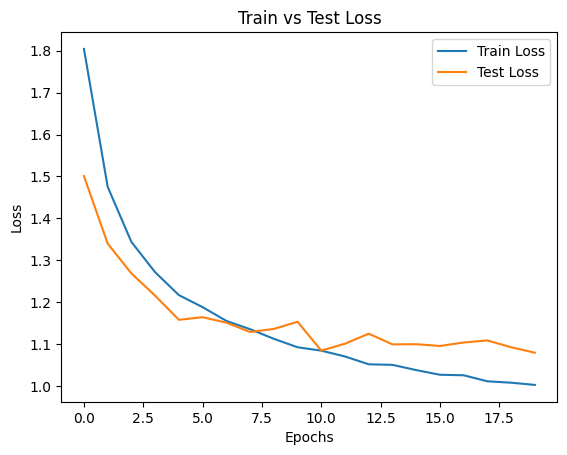

In [77]:
#Train the model on the combined dataset and track the training history
history = best_model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_test_gray, y_test_cat),  # Use the test set as validation data
    batch_size=64,
    epochs=20,
    verbose=1
)

# Step 4: Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_gray, y_test_cat, verbose=0)

# Print test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Step 5: Plot the loss for training and validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')  # Test set used for validation during training
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Solution (c) - Performance Standards and Ethical Concerns with AV's


* Misclassifications in autonomous vehicle (AV) models pose significant ethical risks, particularly in safety-critical scenarios. Failing to detect pedestrians, vehicles, or obstacles can result in life-threatening accidents. Adverse conditions like poor lighting or bad weather may increase these risks, as errors in object detection directly impact human lives. AVs, therefore, require stringent safety standards far beyond traditional software systems.

* Despite their potential to outperform human drivers by reducing accidents caused by fatigue or distraction, deploying imperfect algorithms raises ethical concerns. A small error rate, such as 1% in pedestrian detection, could lead to fatalities. The number of stakeholders becomes complex, involving manufacturers, developers, or owners. Human oversight in critical decisions may mitigate these risks, ensuring systems act responsibly under uncertainty.

* Establishing minimum performance thresholds is crucial. AV models should achieve near-zero false-negative rates for pedestrians and maintain a high F1-Score for critical objects like vehicles and cyclists. Real-time operation with minimal latency is essential to prevent delays in dynamic environments. Acceptable performance levels should reflect the severity of potential consequences, prioritizing safety above all.

* While perfection is impractical, continuous improvement through rigorous testing, real-world data, and model updates is vital. AVs must undergo diverse scenario testing, including edge cases like adverse weather, to ensure robustness. Systems consistently failing in safety-critical tasks should not be deployed, regardless of their performance elsewhere.

* Ultimately, AV deployment demands transparency, accountability, and a focus on minimizing risks to human life. The ethical responsibility to prioritize safety underscores the need for exhaustive testing, high thresholds, and ongoing advancements, ensuring AVs operate as safely as possible in real-world conditions.


# Solution (d)

The below images show the explanation using LIME for automobiles, cats and ships (classes 1,3,8). The results were astonishing and not very accurate which may be (according to me) due to the below factors:

* Low resolution of the image upon which it is turned to gray scale.
* Low acccuracy of 72%.

I have shown LIME explanations using two types of plot:

* Segmentation - Green showing positive areas and red showing negative areas.
* Heat map - Blue showing positive areas and red showing negative areas.

The explanation of boundaries using LIME for some images were satisfactory while for some it was not. According to me the model has not clearly understood the classification task at hand and might heavily misrepresent images in a production setting. Apart from this it was fun to see LIME figure out localized explanations for each image!!

In [70]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9090c304e2eacabef0f15641564c42327fa30eb6c4e19dd6ad7222ce14f0f750
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [154]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [155]:
# Predictions
predicted_classes = np.argmax(best_model.predict(X_test_gray), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [158]:
# Define classes for analysis
selected_classes = [1, 3, 8]
y_test_classes = np.argmax(y_test_cat, axis=1)

# Find correctly and incorrectly classified images
selected_images = {}
for cls in selected_classes:
    correctly_classified = np.where((y_test_classes == cls) & (predicted_classes == cls))[0][:2]
    incorrectly_classified = np.where((y_test_classes == cls) & (predicted_classes != cls))[0][:2]
    selected_images[cls] = {
        "correct": correctly_classified,
        "incorrect": incorrectly_classified
    }

In [161]:
# LIME Explainer
explainer = lime_image.LimeImageExplainer()

def preprocess_for_lime(image):
    return np.stack([image.squeeze()] * 3, axis=-1)

# Function to explain a single image
def explain_image(image_index, title):
    image = X_test_gray[image_index]
    label = y_test_classes[image_index]

    rgb_image = preprocess_for_lime(image)

    # Define a prediction function for LIME
    def predict_fn(images):
        grayscale_images = np.expand_dims(images[..., 0], axis=-1)
        return best_model.predict(grayscale_images)

    explanation = explainer.explain_instance(
        rgb_image.astype('double'),
        predict_fn,
        top_labels=3,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(title)
    plt.axis('off')
    plt.show()

    # Generate and plot the heatmap
    ind = label
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.title(f"{title} - Heatmap")
    plt.colorbar()
    plt.axis('off')

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

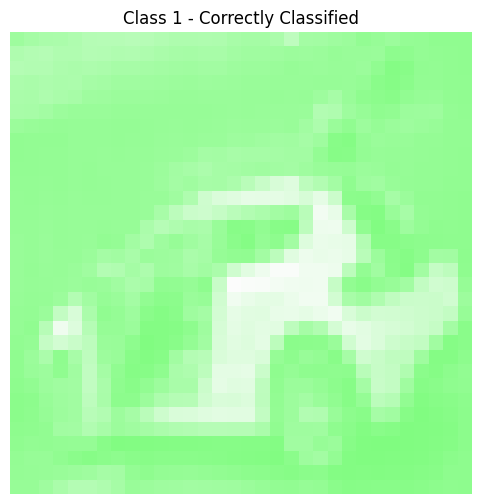

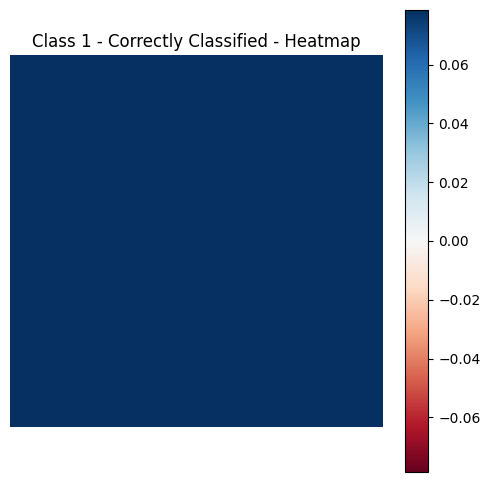

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

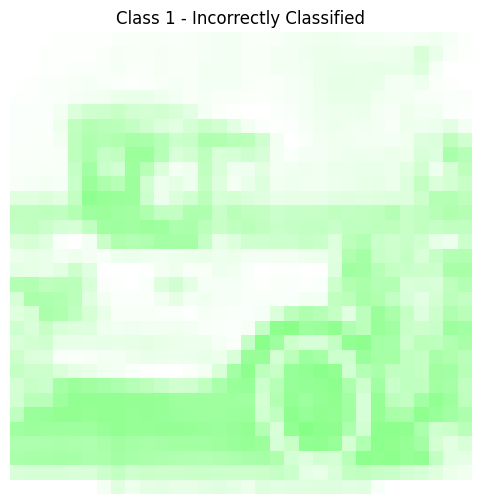

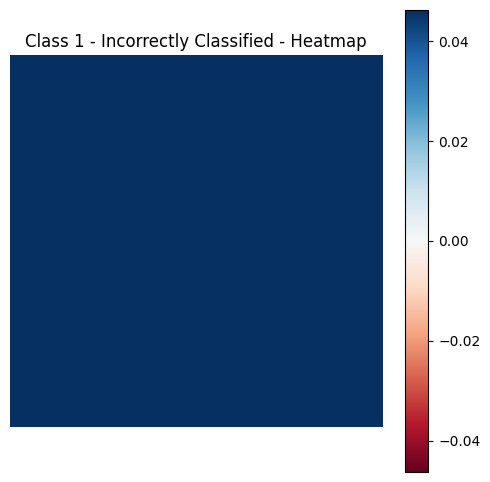

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

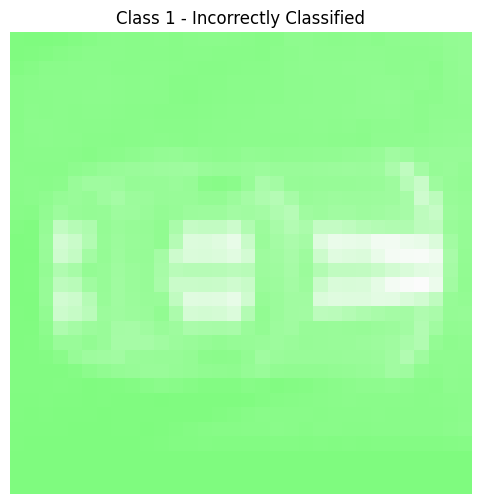

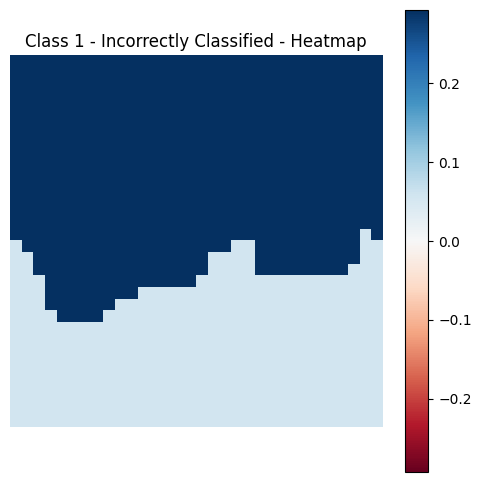

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

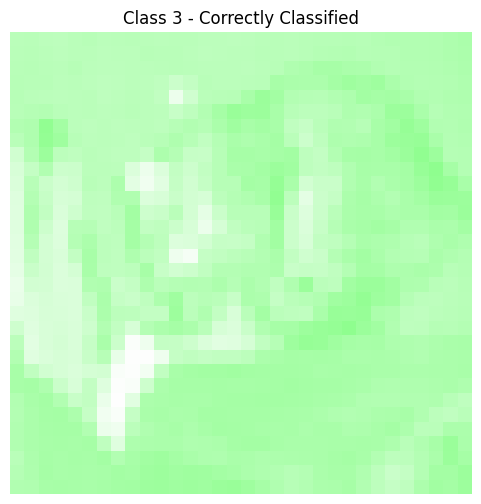

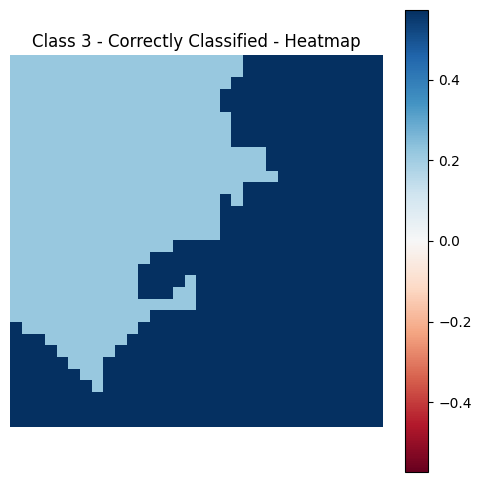

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

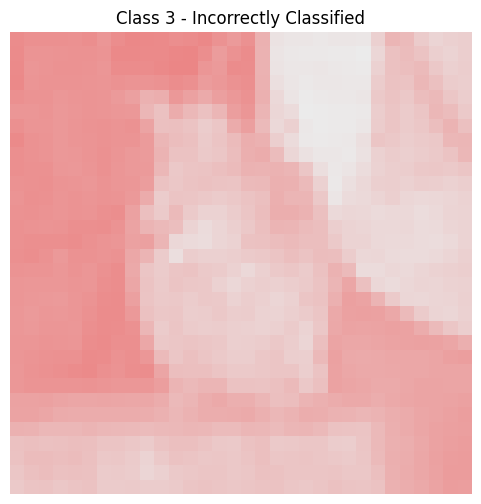

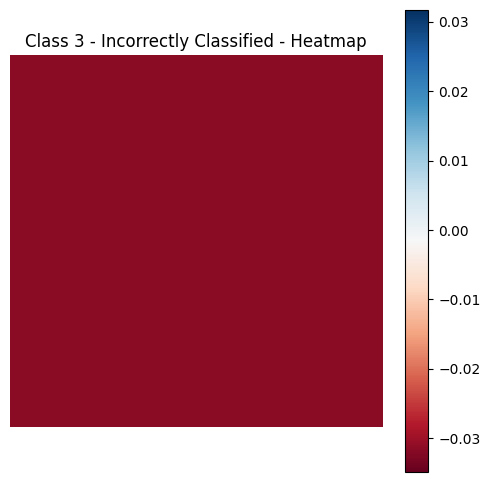

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

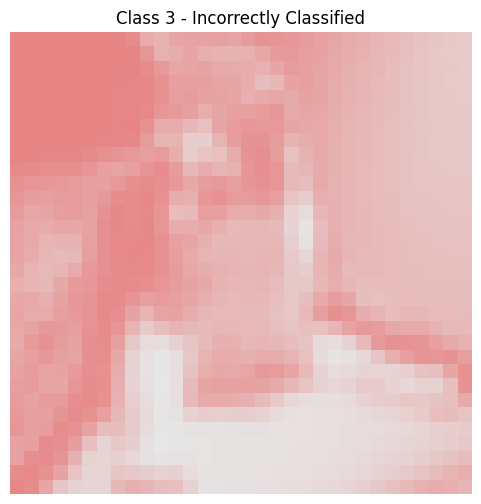

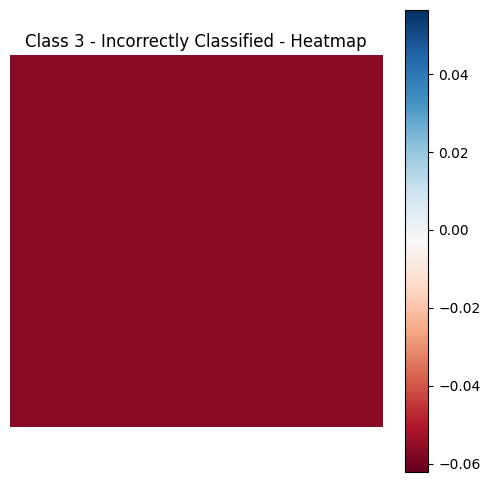

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

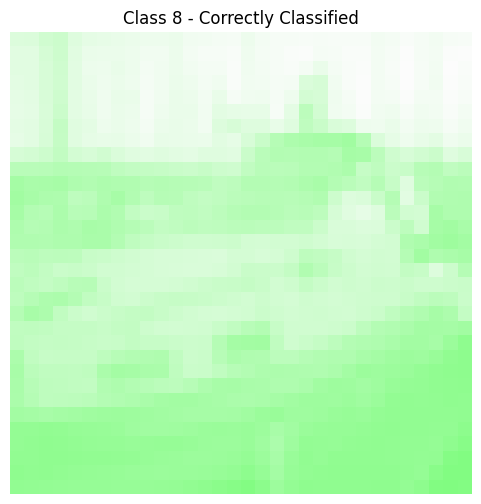

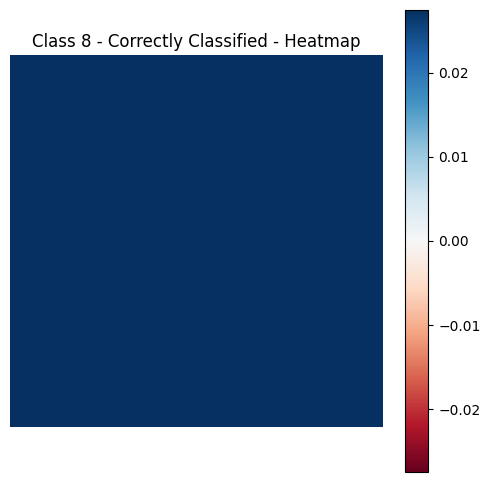

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

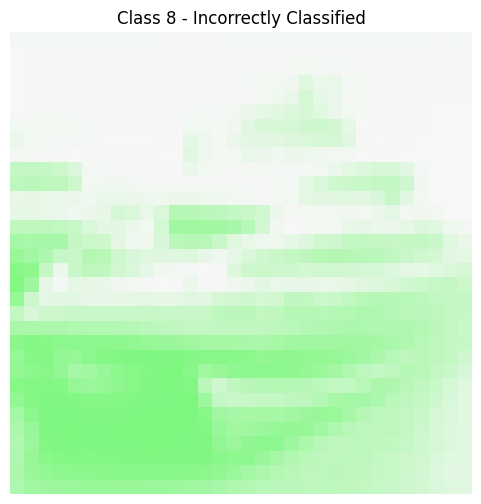

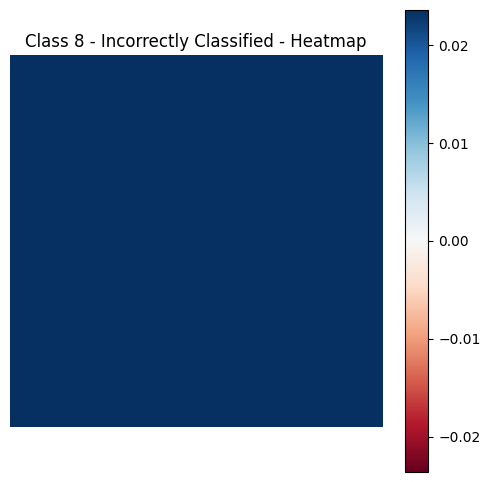

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

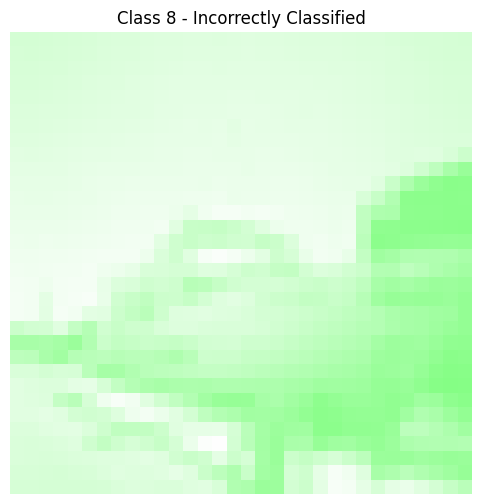

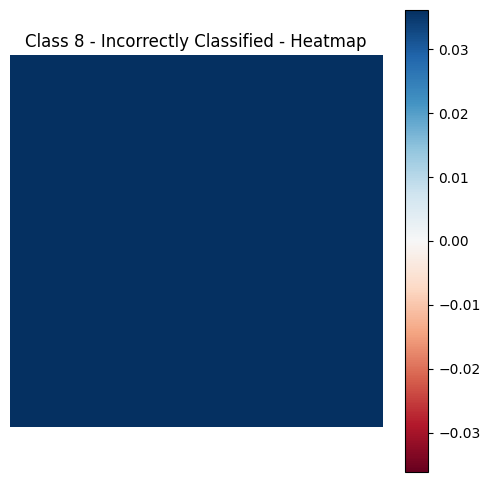

In [162]:
for cls, indices in selected_images.items():
  for idx in indices['correct']:
      explain_image(idx, title=f"Class {cls} - Correctly Classified")
      break

  for idx in indices['incorrect']:
      explain_image(idx, title=f"Class {cls} - Incorrectly Classified")